In [39]:
import pandas as pd
# Task 01
# 1.a: load data frame from file, store into df
df = pd.read_csv('KNNAlgorithmDataset.csv')
#print(df)

#1.c: shuffle the samples
df = df.sample(frac=1)
# frac = [0,1], incase frac = 0.5, shuffle 50% of the rows
#print(df)

# convert data frame into array
data_array = df.values[:, 1:]  #unselect 1st column / label y

# 1.b: set column 'diagnosis' as target variable y / the label
y = df["diagnosis"].values
#print(y) 

In [40]:
# Task 01: normalizing the data with z-score normalization

mean = data_array.mean(axis=0)
standard_deviation = data_array.std(axis=0)

normalized_data = (data_array - mean) / standard_deviation

print(normalized_data)

[[ 1.27315278  0.22348024  1.24110055 ...  0.52370019 -0.90556194
  -0.53951827]
 [-1.08984533  1.93620164 -1.08326245 ... -0.35533128 -1.09160671
  -0.06183392]
 [ 0.44667147  0.23744264  0.38022536 ...  0.60135584  0.86752561
   0.13101312]
 ...
 [-0.6070212   1.30323939 -0.59145146 ...  0.08517419 -0.48817454
  -0.07956699]
 [ 1.59124868  0.12341635  1.59533627 ...  2.07224515 -0.24550745
   2.53550544]
 [-1.1012059  -0.72363608 -1.04825078 ... -0.26138317 -0.47361451
   0.72451653]]


In [41]:
# Task 02: seperate data into training(70%), validation(20%) and test(10%) sets by slicing
da_len = len(data_array)   #number of rows / length of data_array
training_set = data_array[:int(da_len * 0.7)]
#print(training_set)
validation_set = data_array[int(da_len * 0.7): int(da_len * 0.9)]
test_set = data_array[int(da_len* 0.9):]
#print(len(training_set) + len(validation_set) + len(test_set) == da_len) # the whole data array included in the 3 sets: True 

In [42]:
# 3.c distance algorithms with input of two 1D-Vectors, return distance (real number) of 2 vectors(x1,...,xn)
import numpy as np
# Manhattan distance
def manhattan_distance(vector01, vector02):
    # raise error if data points are not of the same length
    if (len(vector01) != len(vector02)):
        raise ValueError("Unequal length of inputed data points")
    # return sum(\xi_m - xj_m\)
    return np.sum(np.abs(vector01 - vector02))    # np.abs(): absolute value of each elements
    # a variante: use np.fabs(v1, v2), return np.sum(np.fabs(vector01 - vector02))

# Euclidean distance
def euclidean_distance(vector01, vector02):
    if (len(vector01) != len(vector02)):
        raise ValueError("Unequal length of inputed data points")
    # use np library: calculate the norm of the new vector (difference of two old vectors)
    return np.linalg.norm(vector01 - vector02)

# Chebyshev distance
def chebyshev_distance(vector01, vector02):
    if (len(vector01) != len(vector02)):
        raise ValueError("Unequal length of inputed data points")
    # return max(\xi_01 - xi_02\)
    absolute_array = [np.abs(vector01[i] - vector02[i]) for i in range(len(vector01))]
    return max(absolute_array)


# test algo with data: 
#t_p01 = training_set[0]
#t_p02 = training_set[1]
#t_short01 = [1.1,2,4.43,8]
#t_short02 = [3,4.7,6,9.69]

#print(manhattan_distance(t_p01, t_p02))    # test (compared with result by online calculator): True
#print(euclidean_distance(t_p01, t_p02))    # definition from numpy library
#print(chebyshev_distance(t_short01, t_short02))    # test: True

In [43]:
# Task 3: implement the kNN algorithm
# accroding to 2.2 kNN algo is capsuled in a kNN predictor
class kNN_predictor:
    #constructor: define attribiutes
    def __init__(self, k, distance_func):    #q: if the k and dist-func is given as param in constructor or later in predict func?
        self.trained = False   #default: not trained
        self.k = k  # k neighbours
        if (distance_func == 'manhattan'):
            self.dname = 'Manhattan distance'
            self.d = manhattan_distance
        elif (distance_func == 'euclidean'):
            self.dname = 'Euclidean distance'
            self.d = euclidean_distance
        elif (distance_func == 'chebyshev'):
            self.dname = 'Chebyshev distance'
            self.d = chebyshev_distance
        # X(data set) and Y(classes / target values) will be provided in fit() as parameters
        self.X = None
        self.Y = None
        # for the normalization
        self.mean = None
        self.std = None
    
    def normalize(self, X):
        if self.trained == False:
            raise("Predictor is not trained! Train it first by calling fit()!")
        return (X - self.mean) / self.std
    
    # functions
    def fit(self, training_X, training_Y):
        #feed the model with training data
        # TODO: normalize X before storing
        self.X = training_X
        self.Y = training_Y
        self.mean = self.X.mean(axis=0)
        self.std = self.X.std(axis=0)
        self.X = self.normalize(self.X)
        self.trained = True   #set trained

    def predict(self, X, thresh=0.5):
        #predict classification or regression result for new data.
        # check if predictor is trained
        if self.trained == False:
            raise("Predictor is not trained! Train it first by calling fit()!")
        
        # TODO: call normalize() to normalize the data
        X = self.normalize(X)
        # TODO: calculate the distance with all the neighbours
        kNN = np.array([])
        for x in X:
            dists = np.array([])
            for y in X:
                dists.append(self.d(x, y))
            dists.sort()
            kNN.append(dists[1:self.k+1])
        
        prob = kNN.mean(axis=0)
        return prob < thresh


    def confusionMatrix(self, X, Y): 
        #compute confusion matrix, input: X (user input)
        '''
        if not self.Y:
            raise error?
        # and validate X and Y shape
        # should be Y given or taken from fit?
            '''
        X = np.array(X)
        Y = np.array(Y)
        pY = np.array(self.predict(X))

        size = len(X)
        # calculate entries of the confusion matrix by counting entries where the corresponding condition is given and make it relative to the whole set
        TP = len(np.where((Y == 1) & (pY == 1))[0])/size
        TN = len(np.where((Y == 0) & (pY == 0))[0])/size
        FP = len(np.where((Y == 0) & (pY == 1))[0])/size
        FN = len(np.where((Y == 1) & (pY == 0))[0])/size
        return [[TP, FN], [FP, TN]]
  

In [44]:
# task 3.2: check if user inputs are valid
def check_predictor_input(k, d):
    valid_dist_algos = ['manhattan', 'euclidean', 'chebyshev']
    # there are k training set rows / neighbours for the new data point
    if k > len(training_set):
        raise ValueError(f"Given k too large! Give a number not larger than {len(training_set)}")
    if d.lower() not in valid_dist_algos:
        raise ValueError(f"Given algorithm is not valid, please choose from {valid_dist_algos}!")
        
#test: passed
#check_predictor_input(100, 'manha')
#check_predictor_input(400, 'chebyshev')

In [45]:
# Task 4: test the data with user inputs
model = kNN_predictor(10, "euclidean") 

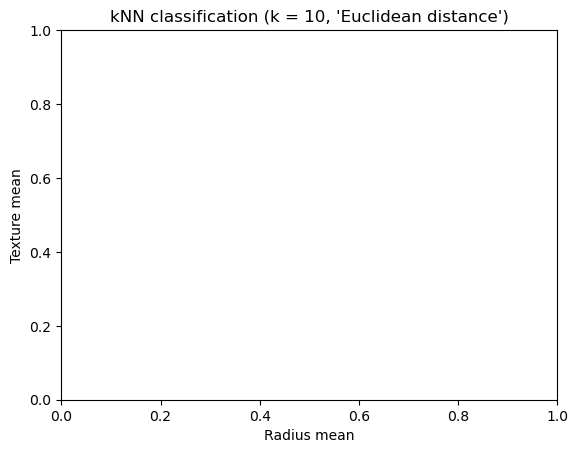

In [46]:
# Task 5: visualization
import matplotlib.pyplot as plt  
plt.xlabel('Radius mean')
plt.ylabel('Texture mean')
plt.title(f"kNN classification (k = {model.k}, '{model.dname}')")
plt.show()